In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from skorch import NeuralNetClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    classification_report, confusion_matrix
    , accuracy_score, ConfusionMatrixDisplay
    )
from torchmetrics import Accuracy, ConfusionMatrix
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
from timeit import default_timer as timer
from tqdm import tqdm

warnings.filterwarnings("ignore")

In [2]:
# MacoOS device agnostic code:

if torch.cuda.is_available():
    device = "cuda" # Use NVIDIA GPU (if available)
elif torch.backends.mps.is_available():
    device = "mps" # Use Apple Silicon GPU (if available)
else:
    device = "cpu" # Default to CPU if no GPU is available

device

'mps'

In [3]:
# ---------------------------------------------------------
# Dataset Preparation
# ---------------------------------------------------------
transform = transforms.Compose([
    transforms.ToTensor()
    , transforms.Normalize((0.5,), (0.5,))
])

# Load datasets (train/test split handled by FashionMNIST)
train_dataset = datasets.FashionMNIST(
    './data', train=True
    , download=True, transform=transform)

test_dataset = datasets.FashionMNIST(
    './data', train=False
    , download=True, transform=transform)

# Use DataLoaders directly, avoiding manual tensor creation
train_loader = DataLoader(
    train_dataset
    , batch_size=256
    , shuffle=True)

test_loader = DataLoader(
    test_dataset
    , batch_size=256
    , shuffle=False)

In [3]:
# # Skorch can handle PyTorch Datasets directly
# X_train, y_train = train_dataset.data.float().unsqueeze(1), train_dataset.targets
# X_test, y_test = test_dataset.data.float().unsqueeze(1), test_dataset.targets

In [4]:
# X_train.shape, y_train.shape, X_test.shape, y_test.shape

In [4]:
# Define the CNN Module

class SimpleCNN(nn.Module):
    def __init__(self, channels=32, dropout=0.0):
        super().__init__()
        self.conv1 = nn.Conv2d(1, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(channels, channels * 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear((channels * 2) * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(self.dropout(x)))
        return self.fc2(x)

In [5]:
# Wrap with Skorch NeuralNetClassifier
net = NeuralNetClassifier(
    module=SimpleCNN
    , criterion=nn.CrossEntropyLoss
    , max_epochs=3
    , lr=0.001
    , optimizer=torch.optim.Adam
    , batch_size=256
    , iterator_train__shuffle=True
    , device=device
)

# Fit the model
net.fit(train_dataset.data.float().unsqueeze(1), train_dataset.targets)

print("Train accuracy:", net.score(
    train_dataset.data.float().unsqueeze(1)
    , train_dataset.targets))

  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.1194       0.8795        0.3395  14.3271
      2        0.3143       0.8852        0.3157  12.5209
      3        0.2704       0.8962        0.2885  12.4446
Train accuracy: 0.9068166666666667


In [7]:
%%time

# RandomizedSearchCV for Hyperparameter Tuning

param_dist = {
    "module__channels": [32, 64]
    , "module__dropout": [0.0, 0.25, 0.5]
    , "lr": [1e-4, 3e-4, 1e-3]
    , "optimizer": [torch.optim.Adam]
    , "batch_size": [256]
}

rs = RandomizedSearchCV(
    estimator=net
    , param_distributions=param_dist
    , n_iter=10
    , cv=2
    , scoring="accuracy"
    , verbose=1
    , random_state=27
    , n_jobs=-1
)

rs.fit(train_dataset.data.float().unsqueeze(1), train_dataset.targets)

print("Best CV accuracy:", rs.best_score_)
print("Best params:", rs.best_params_)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.2033       0.8555        0.4161  8.5565
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.6643       0.8492        0.4259  8.6235
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.3041       0.8422        0.4492  8.9522
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.7790       0.8533        0.4103  10.6743
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.9132       0.8263        0.4774  13.0250
  epoch    train_loss    valid_acc    valid_loss      dur
-------  -----------

In [40]:
# net.fit(X, y)
# print(net.score(X, y))  # should be far above 10%

Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1           nan       0.1000           nan  16.0133
      2           nan       0.1000           nan  16.0808
      3           nan       0.1000           nan  15.7180
      4           nan       0.1000           nan  15.4871
      5           nan       0.1000           nan  15.7791
      6           nan       0.1000           nan  16.5335
      7           nan       0.1000           nan  17.8743
      8           nan       0.1000           nan  15.5864
      9           nan       0.1000           nan  15.1555
     10           nan       0.1000           nan  16.5533
0.1


In [8]:
# Send results to a dataframe for clean review;

results = pd.DataFrame(rs.cv_results_)
results[[
    "mean_test_score"
    , "std_test_score"
    , "params"
]].sort_values("mean_test_score", ascending=False, inplace=True)
results.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_optimizer,param_module__dropout,param_module__channels,param_lr,param_batch_size,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,983.723547,79.602933,198.510707,7.627952,<class 'torch.optim.adam.Adam'>,0.25,32,0.0003,256,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",0.8805,0.880067,0.880283,0.000217,2
1,751.929575,93.080989,193.605317,7.312273,<class 'torch.optim.adam.Adam'>,0.50,32,0.0010,256,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",0.8707,0.869700,0.870200,0.000500,8
2,1081.055782,43.632520,195.080707,5.068734,<class 'torch.optim.adam.Adam'>,0.00,32,0.0001,256,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",0.8479,0.868467,0.858183,0.010283,9


In [10]:
# Evaluate Performance with Best Model
# ---------------------------------------------------------
best_model = rs.best_estimator_
best_model.get_params_for_optimizer

<bound method NeuralNet.get_params_for_optimizer of <class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=SimpleCNN(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fc1): Linear(in_features=3136, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=10, bias=True)
    (dropout): Dropout(p=0.25, inplace=False)
  ),
)>

In [12]:
y_pred = best_model.predict(test_dataset.data.float().unsqueeze(1))

# Print metrics
print("Accuracy:", accuracy_score(test_dataset.targets, y_pred))
print("Classification Report:\\n", classification_report(test_dataset.targets, y_pred))

# Confusion Matrix
cm = ConfusionMatrix(num_classes=10, task='multiclass')
cm_tensor = cm(torch.tensor(y_pred), test_dataset.targets)

Accuracy: 0.8838
Classification Report:\n               precision    recall  f1-score   support

           0       0.82      0.82      0.82      1000
           1       0.99      0.97      0.98      1000
           2       0.79      0.83      0.81      1000
           3       0.87      0.92      0.89      1000
           4       0.78      0.80      0.79      1000
           5       0.98      0.96      0.97      1000
           6       0.72      0.62      0.67      1000
           7       0.95      0.96      0.96      1000
           8       0.97      0.98      0.97      1000
           9       0.96      0.97      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



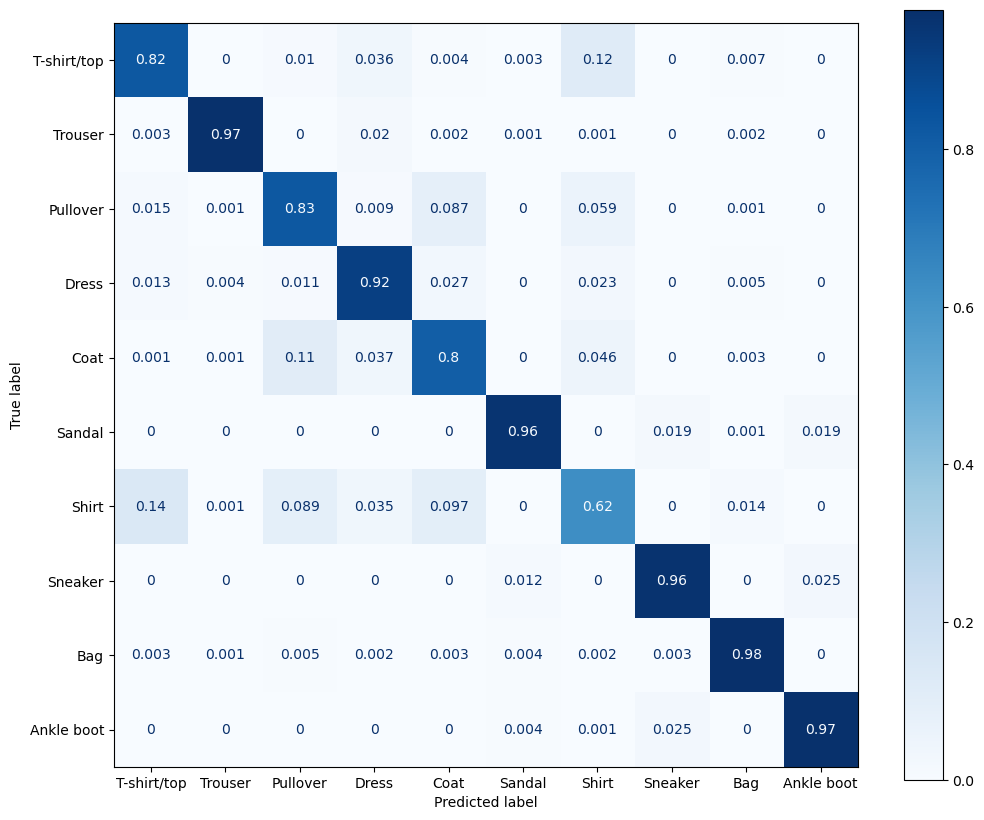

In [23]:
fig, ax = plt.subplots(figsize=(12, 10)) 

# Plot confusion matrix
# disp = ConfusionMatrixDisplay.from_predictions(
#     test_dataset.targets, y_pred
#     , display_labels=train_dataset.classes
#     , cmap='Blues'
#     , normalize='true', xticks_rotation=45
# );

disp.plot(ax=ax, cmap='Blues')
plt.show();

In [25]:
# Training/Test Loops (PyTorch Native)

def train_step(model, loader, loss_fn, optimizer, accuracy_fn, device):
    model.train()
    total_loss, total_acc = 0, 0
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += accuracy_fn(y_pred.argmax(dim=1), y).item()
    return total_loss / len(loader), total_acc / len(loader)

def test_step(model, loader, loss_fn, accuracy_fn, device):
    model.eval()
    total_loss, total_acc = 0, 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            total_loss += loss.item()
            total_acc += accuracy_fn(y_pred.argmax(dim=1), y).item()
    return total_loss / len(loader), total_acc / len(loader)

In [24]:
# Set the final model with the best params (need to incl channels & dropout as such:)
model = SimpleCNN(
    channels=rs.best_params_["module__channels"]
    , dropout=rs.best_params_["module__dropout"]
).to(device)

model

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [27]:
%%time

# Train the Best Model

optimizer = rs.best_params_["optimizer"](model.parameters(), lr=rs.best_params_["lr"])
loss_fn = nn.CrossEntropyLoss()
accuracy_fn = Accuracy(task='multiclass', num_classes=10).to(device)

epochs = 20
for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(
        model, train_loader, loss_fn, optimizer, accuracy_fn, device)
    test_loss, test_acc = test_step(
        model, test_loader, loss_fn, accuracy_fn, device)
    print(
        f"Epoch {epoch+1}/{epochs} - "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f} - "
        f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}"
    )

  5%|██▏                                         | 1/20 [00:32<10:23, 32.81s/it]

Epoch 1/20 - Train Loss: 0.5316, Train Acc: 0.81 - Test Loss: 0.3961, Test Acc: 0.85


 10%|████▍                                       | 2/20 [00:59<08:40, 28.93s/it]

Epoch 2/20 - Train Loss: 0.3500, Train Acc: 0.87 - Test Loss: 0.3272, Test Acc: 0.88


 15%|██████▌                                     | 3/20 [01:25<07:50, 27.68s/it]

Epoch 3/20 - Train Loss: 0.3016, Train Acc: 0.89 - Test Loss: 0.2873, Test Acc: 0.90


 20%|████████▊                                   | 4/20 [01:51<07:16, 27.29s/it]

Epoch 4/20 - Train Loss: 0.2719, Train Acc: 0.90 - Test Loss: 0.2723, Test Acc: 0.90


 25%|███████████                                 | 5/20 [02:18<06:45, 27.07s/it]

Epoch 5/20 - Train Loss: 0.2498, Train Acc: 0.91 - Test Loss: 0.2572, Test Acc: 0.91


 30%|█████████████▏                              | 6/20 [02:45<06:17, 26.94s/it]

Epoch 6/20 - Train Loss: 0.2291, Train Acc: 0.92 - Test Loss: 0.2510, Test Acc: 0.91


 35%|███████████████▍                            | 7/20 [03:11<05:48, 26.80s/it]

Epoch 7/20 - Train Loss: 0.2147, Train Acc: 0.92 - Test Loss: 0.2419, Test Acc: 0.91


 40%|█████████████████▌                          | 8/20 [03:38<05:21, 26.77s/it]

Epoch 8/20 - Train Loss: 0.2026, Train Acc: 0.93 - Test Loss: 0.2387, Test Acc: 0.92


 45%|███████████████████▊                        | 9/20 [04:05<04:54, 26.74s/it]

Epoch 9/20 - Train Loss: 0.1912, Train Acc: 0.93 - Test Loss: 0.2292, Test Acc: 0.92


 50%|█████████████████████▌                     | 10/20 [04:31<04:27, 26.73s/it]

Epoch 10/20 - Train Loss: 0.1780, Train Acc: 0.93 - Test Loss: 0.2300, Test Acc: 0.92


 55%|███████████████████████▋                   | 11/20 [04:58<04:00, 26.72s/it]

Epoch 11/20 - Train Loss: 0.1688, Train Acc: 0.94 - Test Loss: 0.2382, Test Acc: 0.92


 60%|█████████████████████████▊                 | 12/20 [05:25<03:33, 26.72s/it]

Epoch 12/20 - Train Loss: 0.1571, Train Acc: 0.94 - Test Loss: 0.2385, Test Acc: 0.91


 65%|███████████████████████████▉               | 13/20 [05:51<03:06, 26.71s/it]

Epoch 13/20 - Train Loss: 0.1504, Train Acc: 0.94 - Test Loss: 0.2291, Test Acc: 0.92


 70%|██████████████████████████████             | 14/20 [06:18<02:40, 26.71s/it]

Epoch 14/20 - Train Loss: 0.1385, Train Acc: 0.95 - Test Loss: 0.2307, Test Acc: 0.92


 75%|████████████████████████████████▎          | 15/20 [06:45<02:13, 26.74s/it]

Epoch 15/20 - Train Loss: 0.1354, Train Acc: 0.95 - Test Loss: 0.2263, Test Acc: 0.93


 80%|██████████████████████████████████▍        | 16/20 [07:12<01:47, 26.76s/it]

Epoch 16/20 - Train Loss: 0.1243, Train Acc: 0.95 - Test Loss: 0.2305, Test Acc: 0.93


 85%|████████████████████████████████████▌      | 17/20 [07:39<01:20, 26.75s/it]

Epoch 17/20 - Train Loss: 0.1180, Train Acc: 0.96 - Test Loss: 0.2378, Test Acc: 0.93


 90%|██████████████████████████████████████▋    | 18/20 [08:05<00:53, 26.78s/it]

Epoch 18/20 - Train Loss: 0.1102, Train Acc: 0.96 - Test Loss: 0.2388, Test Acc: 0.92


 95%|████████████████████████████████████████▊  | 19/20 [08:32<00:26, 26.82s/it]

Epoch 19/20 - Train Loss: 0.1037, Train Acc: 0.96 - Test Loss: 0.2467, Test Acc: 0.92


100%|███████████████████████████████████████████| 20/20 [08:59<00:00, 26.98s/it]

Epoch 20/20 - Train Loss: 0.0965, Train Acc: 0.96 - Test Loss: 0.2494, Test Acc: 0.92
CPU times: user 6min 4s, sys: 1min 9s, total: 7min 14s
Wall time: 9min


In [29]:
# Final Confusion Matrix for FashionMNIST

# Ensure the model is in evaluation mode
model.eval()

# Collect all predictions and true labels
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        # Send data to device
        images, labels = images.to(device), labels.to(device)

        # Get predictions
        outputs = model(images)
        preds = outputs.argmax(dim=1)

        # Store predictions and true labels
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

# Concatenate all predictions and labels into single tensors
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

In [45]:
print(confusion_matrix(all_labels, all_preds))
print('\n=================================================================\n')
print(classification_report(all_labels, all_preds))

[[869   0   9   8   2   1 109   0   2   0]
 [  1 987   0   5   0   1   5   0   1   0]
 [ 20   1 888   4  36   0  51   0   0   0]
 [ 27   3  10 907   7   0  45   0   1   0]
 [  2   2  42  24 875   0  55   0   0   0]
 [  0   0   0   0   0 985   0  13   0   2]
 [ 91   0  52  12  43   0 794   0   8   0]
 [  0   0   0   0   0   6   0 981   0  13]
 [  5   1   0   4   1   1   2   2 984   0]
 [  0   0   0   0   0   7   2  37   0 954]]


              precision    recall  f1-score   support

           0       0.86      0.87      0.86      1000
           1       0.99      0.99      0.99      1000
           2       0.89      0.89      0.89      1000
           3       0.94      0.91      0.92      1000
           4       0.91      0.88      0.89      1000
           5       0.98      0.98      0.98      1000
           6       0.75      0.79      0.77      1000
           7       0.95      0.98      0.97      1000
           8       0.99      0.98      0.99      1000
           9       0.98   

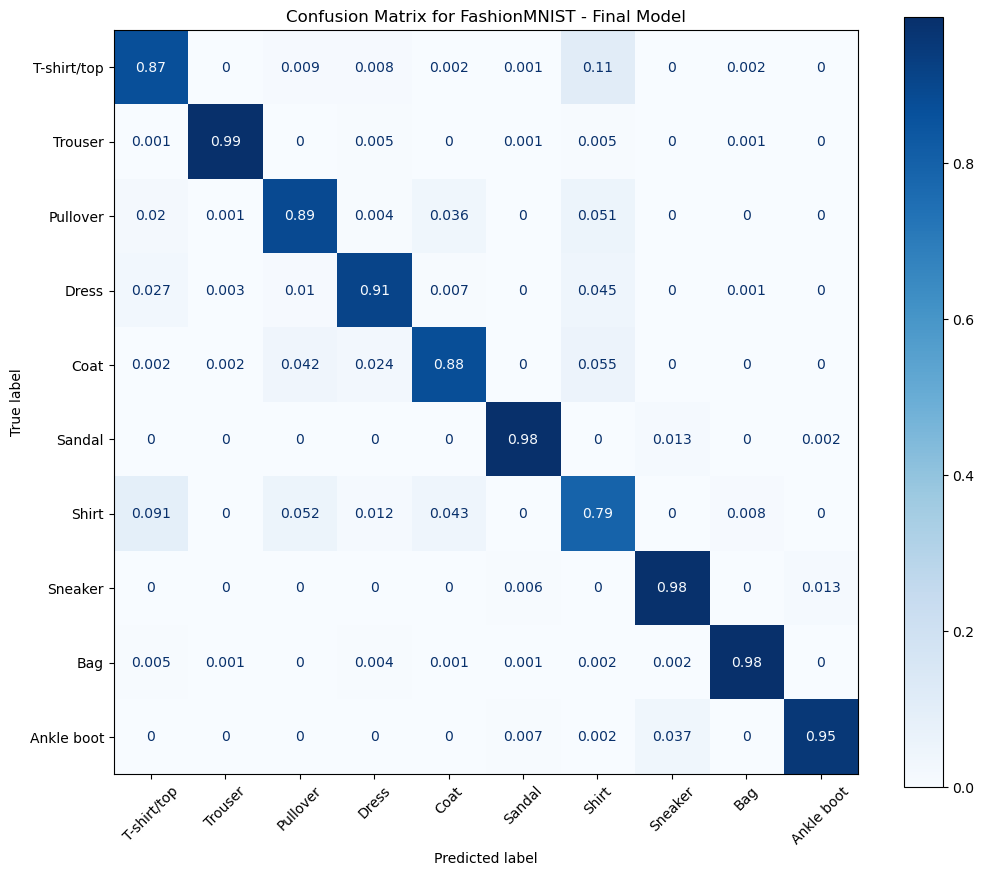

In [46]:
# Compute the confusion matrix

fig, ax = plt.subplots(figsize=(12, 10)) 

# Display the normalized confusion matrix
# disp = ConfusionMatrixDisplay.from_predictions(
#     all_labels, all_preds
#     , display_labels=train_dataset.classes  # Use FashionMNIST class names
#     , normalize='true'
# )
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix for FashionMNIST - Final Model")
plt.show();